<a href="https://colab.research.google.com/github/RegaipKURT/Machine-Learning-Python/blob/master/Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [0]:
!pip3 install arch yfinance pmdarima

In [2]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading the data

In [3]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2020-03-31", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [0]:
df_comp = raw_data.copy()

In [0]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

In [0]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

### Creating Returns

In [0]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1)*100
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1)*100
df_comp['ret_dax'] = df_comp.dax.pct_change(1)*100
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1)*100

### Splitting the Data

In [0]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### Fitting a Model

In [0]:
from pmdarima.arima import auto_arima

In [0]:
model_auto = auto_arima(df.ret_ftse[1:])

In [11]:
model_auto

ARIMA(maxiter=50, method='lbfgs', order=(3, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [12]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5472
Model:               SARIMAX(3, 0, 5)   Log Likelihood               -8458.667
Date:                Wed, 01 Apr 2020   AIC                          16937.334
Time:                        23:50:27   BIC                          17003.408
Sample:                             0   HQIC                         16960.386
                               - 5472                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0449      0.033      1.348      0.178      -0.020       0.110
ar.L1         -0.1537      0.076     -2.020      0.043      -0.303      -0.005
ar.L2         -0.8716      0.019    -45.778      0.000      -0.909      -0.834
ar.L3         -0.3082      0.070     -4.391      0.000      -0.446      -0.171
ma.L1          0.1294      0.076      1.695      0.090      -0.020       0.279
ma.L2          0.8198      0.022     37.409      0.000       0.777       0.863
ma.L3          0.2021      0.069      2.921      0.003       0.066       0.338
ma.L4         -0.0101      0.009     -1.165      0.244      -0.027       0.007
ma.L5         -0.1055      0.008    -13.079      0.000      -0.121      -0.090
sigma2         1.2890      0.013     95.996      0.000       1.263       1.315
===================================================================================
Ljung-Box (Q):                       75.70   Jarque-Bera (JB):              7360.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Important Arguments

In [0]:
model_auto = auto_arima(df_comp.ret_ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df_comp)*0.2))

# !!! Important Note: In pdmarima v1.5.2, out_of_sample_size is replaced with out_of_sample, so make sure to use the latter!

# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length
# max_order -> maximum amount of variables to be used in the regression (p + q)
# max_p -> maximum AR components
# max_q -> maximum MA components
# max_d -> maximum Integrations
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_smaple -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [14]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6841
Model:             SARIMAX(2, 0, 2)x(1, 0, 1, 5)   Log Likelihood               -6836.991
Date:                           Wed, 01 Apr 2020   AIC                          13697.981
Time:                                   23:55:01   BIC                          13779.950
Sample:                               01-11-1994   HQIC                         13726.259
                                    - 03-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0031      0.008     -0.399      0.690      -0.018       0.012
drift       -2.28e-06   2.34e-06     -0.974      0.330   -6.87e-06    2.31e-06
ret_spx        0.1053      0.005     19.826      0.000       0.095       0.116
ret_dax        0.5618      0.005    120.001      0.000       0.553       0.571
ret_nikkei     0.0706      0.004     17.777      0.000       0.063       0.078
ar.L1         -0.2066      0.088     -2.357      0.018      -0.378      -0.035
ar.L2          0.5427      0.054      9.988      0.000       0.436       0.649
ma.L1          0.1060      0.088      1.209      0.227      -0.066       0.278
ma.L2         -0.5764      0.052    -11.166      0.000      -0.678      -0.475
ar.S.L5        0.0520      0.325      0.160      0.873      -0.585       0.689
ma.S.L5       -0.0804      0.325     -0.247      0.805      -0.718       0.558
sigma2         0.4306      0.004    105.327      0.000       0.423       0.439
===================================================================================
Ljung-Box (Q):                       86.07   Jarque-Bera (JB):             16818.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

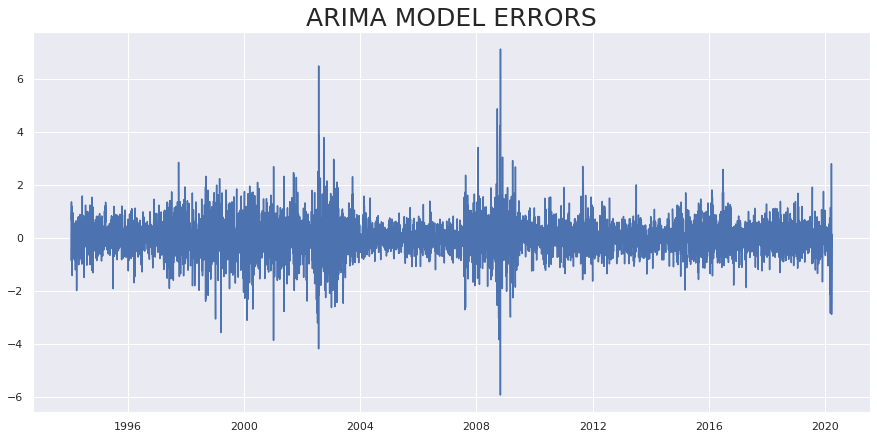

In [18]:
plt.figure(figsize=(15,7))
plt.plot(model_auto.resid())
plt.title("ARIMA MODEL ERRORS", size=25)
plt.show()